In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

Pipeline and preprocessing packages imported!


In [3]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
print('Algorithm packages imported!')

Algorithm packages imported!


In [4]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

Model selection packages imported!


In [5]:
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
print('Statistical packages imported!')

Statistical packages imported!


In [6]:
# Metrics used for measuring the accuracy and performance of the models
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print('Metrics packages imported!')

Metrics packages imported!


In [7]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

Deprecation warning will be ignored!


## Загрузка данных:

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('hhouse2.csv')
price = pd.read_csv('hhouse.csv', names=['my_datetime'])
test = pd.read_csv('hhouse3.csv')
test2=pd.read_csv("test.csv")

## Отмасштабируем данные, чтобы масштаб был от 0 до 1 и все алгоритмы могли работать корректно:

In [0]:
sc=RobustScaler()
train=sc.fit_transform(train)
test=sc.transform(test)

In [11]:
print(train.shape)
print(test.shape)

(1456, 331)
(1459, 331)


# Уменьшим количество признаков,оставив наиболее важные:

In [12]:
xgb_train = train.copy()
xgb_test = test.copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(xgb_train, price)

# Allow the feature importances attribute to select the most important features
xgb_feat_red = SelectFromModel(model, prefit = True)

# Reduce estimation, validation and test datasets
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

[23:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Results of 'feature_importances_':
X_train:  (1456, 48) 
X_test:  (1459, 48)


## Разделим данные и обучим на лучшем алгоритме,который показал оптимальные результаты после испытаний:

In [0]:
X_train, X_val, y_train, y_val = train_test_split(xgb_train, price, test_size=0.2, shuffle=False)

In [0]:
model=Lasso(alpha =0.001, random_state=1)


In [0]:
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [16]:
mean_absolute_error(pred, y_val)

0.08186685875830978

## Обучим алгоритм на всех данных и сделаем предсказание:

In [0]:
model=Lasso(alpha =0.001, random_state=1)

In [18]:
model.fit(xgb_train,price)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
prediction = model.predict(xgb_test)
preds=np.exp(prediction)

In [0]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('price_house_01.csv', index=False)

## Переберём различные варианты параметров алгоритма, используя GridSearchCV и выберем самые оптимальные:

In [0]:
model=Lasso(random_state=1)

In [0]:
ww = np.linspace(-0.1,0.1,20)

In [0]:
LASS_param_grid = {'alpha': [0.0005050505050505048], 'max_iter': [100,200,300,350,400,500], 'tol': ww}

In [0]:
GS = GridSearchCV(model,LASS_param_grid, scoring = 'neg_mean_absolute_error', cv = 10 )

In [25]:
GS.fit(xgb_train,price)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0005050505050505048],
                         'max_iter': [100, 200, 300, 350, 400, 500],
                         'tol': array([-0.1       , -0.08947368, -0.07894737, -0.06842105, -0.05789474,
       -0.04736842, -0.03684211, -0.02631579, -0.01578947, -0.00526316,
        0.00526316,  0.01578947,  0.02631579,  0.03684211,  0.04736842,
        0.05789474,  0.06842105,  0.07894737,  0.08947368,  0.1       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [26]:
print(GS.best_params_)
print(GS.best_score_)

{'alpha': 0.0005050505050505048, 'max_iter': 500, 'tol': -0.1}
-0.08483518465018755


## Обучим алгоритм c новыми параметрами на всех данных и сделаем предсказание:

In [0]:
BestModel = GS.best_estimator_

In [0]:
prediction = BestModel.predict(xgb_test)
preds=np.exp(prediction)

In [0]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('price_house_02.csv', index=False)

## Сделаем стекинг и блэндинг:

In [0]:
price2 = price["my_datetime"]

In [31]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, price2, test_size=0.3, random_state=42)

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (1019, 48) 
X_test:  (437, 48) 
Y_train:  (1019,) 
Y_test:  (437,)


In [32]:
import xgboost as xgb
#Machine Learning Algorithm (MLA) Selection and Initialization
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, Y_train)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
[23:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...",251.763,235.119
1,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",38.973,38.721
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",38.973,38.721
3,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",12.695,12.310
4,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_in...",11.746,11.863
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 2....",12.220,12.504
6,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",13.514,14.156
7,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",12.658,12.158


In [33]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(gs_best)
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare

KernelRidge(alpha=0.1, coef0=100, degree=1, gamma=None, kernel='polynomial',
            kernel_params=None)
1 KernelRidge trained...
ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.6,
           max_iter=300, normalize=False, positive=False, precompute=False,
           random_state=None, selection='random', tol=0.001, warm_start=False)
2 ElasticNet trained...
Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=300,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='random', tol=0.01, warm_start=False)
3 Lasso trained...
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=0.0025,
                       

,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...",11.735,11.889
1,ElasticNet,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep...",11.799,11.877
2,Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",11.850,11.832
3,GradientBoostingRegressor,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",12.177,12.249
4,BayesianRidge,"{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...",11.746,11.863
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 1e...",12.214,12.504
6,RandomForestRegressor,"{'max_depth': None, 'max_features': 'auto', 'm...",13.663,14.152
7,XGBRegressor,"{'booster': 'gbtree', 'colsample_bylevel': 0.2...",12.246,11.753


In [34]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = gs_best.predict(xgb_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------
2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------
3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------
6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added

In [35]:
stacked_validation_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,12.073728,12.051503,12.056283,12.115832,12.075085,12.044550,12.107718,12.105165
1,11.909246,11.918362,11.916213,12.041782,11.911173,11.956942,12.068145,12.023828
2,11.785589,11.785172,11.785755,11.874111,11.786584,11.768158,11.859008,11.766501
3,11.814794,11.809117,11.821062,11.838076,11.815880,11.793635,11.756246,11.756207
4,11.357140,11.353345,11.353980,11.175413,11.357378,11.363881,11.329136,11.344832


In [36]:
stacked_test_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,11.636958,11.640491,11.640737,11.720710,11.640184,11.657661,11.720434,11.681759
1,11.990914,11.988131,11.989119,11.959877,11.990921,11.956845,11.950297,11.990759
2,12.097899,12.087417,12.086462,12.130536,12.098948,12.039650,12.088913,12.120154
3,12.189059,12.181919,12.177527,12.145993,12.189636,12.123748,12.110254,12.101163
4,12.088862,12.095866,12.091821,12.135041,12.087660,12.126271,12.147147,12.121401


In [37]:
drop = ['Lasso']
stacked_validation_train.drop(drop, axis=1, inplace=True)
stacked_test_train.drop(drop, axis=1, inplace=True)

# Now fit the meta model and generate predictions
meta_model = make_pipeline(RobustScaler(), Lasso(alpha=0.00001, copy_X = True, fit_intercept = True,
                                              normalize = False, precompute = False, max_iter = 10000,
                                              tol = 0.0001, selection = 'random', random_state = None))
meta_model.fit(stacked_validation_train, Y_test)

meta_model_pred = np.expm1(meta_model.predict(stacked_test_train))
print("Meta-model trained and applied!...")

Meta-model trained and applied!...


In [38]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(stacked_validation_train, Y_test)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = names[0], value = np.expm1(gs_best.predict(stacked_test_train)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...
4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...
6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
[23:08:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
Done


,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,116575.696401,116829.520329,115349.088702,123170.581757,116856.502080,116757.884849,116195.992759,118909.648438
1,160035.249658,159819.032922,159980.869704,158303.464773,160994.542236,160021.427604,156541.601135,164992.812500
2,182244.850863,182087.162205,181330.711352,176263.452313,184060.941612,182557.884484,176715.055592,174534.984375
3,190050.308068,189536.184835,193181.635788,184512.167030,190822.870922,189319.232800,186471.959551,189181.218750
4,181735.754533,182045.601501,179973.435174,176293.371555,181060.638490,181938.304297,177296.862943,178455.328125


## Сделаем несколько вариантов блэндинг различных моделей:

In [39]:
ensemble = meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(2.5/10) + final_predictions['Lasso']*(1/10) + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['KernelRidge']*(1/10)

submission = pd.DataFrame()
submission['Id'] =test2['Id']
submission['SalePrice'] = ensemble
submission.to_csv('final_submission.csv',index=False)
print("Файл сохранён!")

Файл сохранён!


In [40]:
ensemble2 = (meta_model_pred + final_predictions['XGBoost'] + final_predictions['Gradient Boosting'] + final_predictions['Bayesian Ridge'] + final_predictions['Lasso'] + final_predictions['KernelRidge'] + final_predictions['Lasso Lars IC'] + final_predictions['Random Forest'])/8

submission = pd.DataFrame()
submission['Id'] =test2['Id']
submission['SalePrice'] = ensemble2
submission.to_csv('final_submission2.csv',index=False)
print("Файл сохранён!")

Файл сохранён!


In [41]:
ensemble3 = (meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10)
            + final_predictions['Bayesian Ridge']*(1/10) + final_predictions['Lasso']*(1/10) + final_predictions['KernelRidge']*(1/10)
            + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['Random Forest']*(1.5/10))

submission = pd.DataFrame()
submission['Id'] =test2['Id']
submission['SalePrice'] = ensemble3
submission.to_csv('final_submission3.csv',index=False)
print("Файл сохранён!")

Файл сохранён!


## Попробуем применить нейросеть:

In [0]:
import torch 
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

In [0]:
x_data = torch.Tensor(xgb_train)

In [0]:
y_data= torch.Tensor(price2)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print('X_train: ', X_train.shape, '\nX_val: ', X_val.shape, '\nY_train: ', Y_train.shape, '\ny_val: ', y_val.shape)

X_train:  torch.Size([1164, 48]) 
X_val:  torch.Size([292, 48]) 
Y_train:  (1019,) 
y_val:  torch.Size([292])


In [0]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(48, n_hidden_neurons)
        #self.act1 = torch.nn.Sigmoid()
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

sine_net = SineNet(50)

No handles with labels found to put in legend.


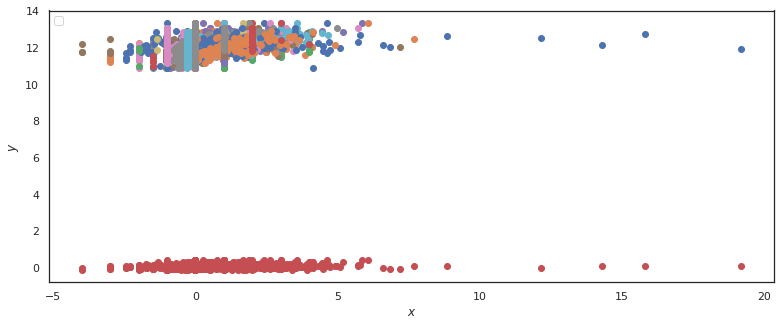

In [47]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sine_net, X_val, y_val)

In [0]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)

In [0]:
def loss(pred, target):
    squares = (pred - target) ** 2
    return squares.mean()

In [0]:
def metric(y_pred, target):
    return ((y_pred - target)**2).mean()

No handles with labels found to put in legend.


0.15677961707115173


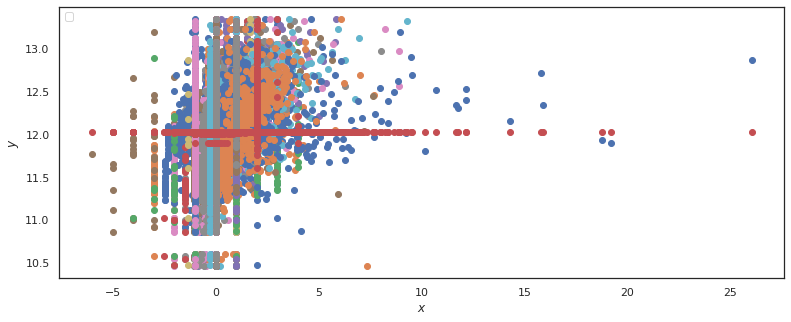

In [51]:
for epoch_index in range(2000):
    optimizer.zero_grad()

    y_pred = sine_net.forward(x_data)
    loss_val = loss(y_pred, y_data)

    loss_val.backward()

    optimizer.step()

predict(sine_net, x_data, y_data)
print(metric(sine_net.forward(x_data), y_data).item())